In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1 Datasets preparation


###1.1 load libary

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models

np.random.seed(5328)
tf.random.set_seed(5328)

###1.2 Load datasets

In [ ]:
dataset_F3 = np.load('/content/drive/MyDrive/5328data/FashionMNIST0.3.npz')

# Load the training, validation, and test data
Xtr_F3 = dataset_F3['X_tr']
Str_F3 = dataset_F3['S_tr']
Xts_F3 = dataset_F3['X_ts']
Yts_F3 = dataset_F3['Y_ts']

print("Training and Validation Data Shape:", Xtr_F3.shape)
print("Noisy labels Shape:", Str_F3.shape)
print("Test Data Shape:", Xts_F3.shape)
print("Test Labels Shape:", Yts_F3.shape)

Training and Validation Data Shape: (24000, 28, 28)
Noisy labels Shape: (24000,)
Test Data Shape: (4000, 28, 28)
Test Labels Shape: (4000,)


In [ ]:
dataset_F6 = np.load('/content/drive/MyDrive/5328data/FashionMNIST0.6.npz')

# Load the training, validation, and test data
Xtr_F6 = dataset_F6['X_tr']
Str_F6 = dataset_F6['S_tr']
Xts_F6 = dataset_F6['X_ts']
Yts_F6 = dataset_F6['Y_ts']

print("Training and Validation Data Shape:", Xtr_F6.shape)
print("Noisy Labels Shape:", Str_F6.shape)
print("Test Data Shape:", Xts_F6.shape)
print("Test Labels Shape:", Yts_F6.shape)

Training and Validation Data Shape: (24000, 28, 28)
Noisy Labels Shape: (24000,)
Test Data Shape: (4000, 28, 28)
Test Labels Shape: (4000,)


In [ ]:
dataset_C10 = np.load('/content/drive/MyDrive/5328data/CIFAR10.npz')

# Load the training, validation, and test data
Xtr_C10 = dataset_C10['X_tr']
Str_C10 = dataset_C10['S_tr']
Xts_C10 = dataset_C10['X_ts']
Yts_C10 = dataset_C10['Y_ts']

print("Training and Validation Data Shape:", Xtr_C10.shape)
print("Noisy labels Shape:", Str_C10.shape)
print("Test Data Shape:", Xts_C10.shape)
print("Test Labels Shape:", Yts_C10.shape)

Training and Validation Data Shape: (20000, 32, 32, 3)
Noisy labels Shape: (20000,)
Test Data Shape: (4000, 32, 32, 3)
Test Labels Shape: (4000,)


### 1.3 Display Images in datasets

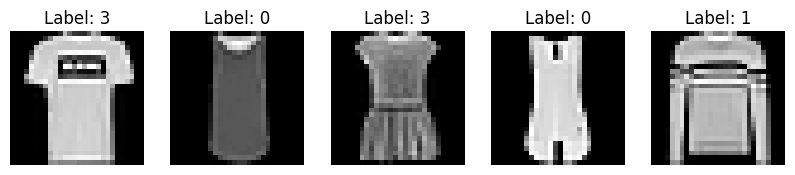

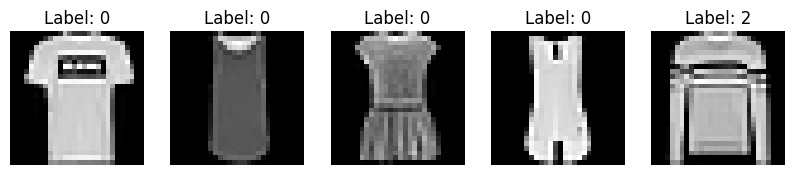

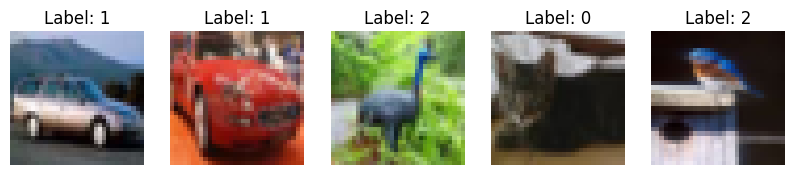

In [ ]:
def display_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

display_images(Xtr_F6, Str_F6, num_images=5)
display_images(Xtr_F3, Str_F3, num_images=5)
display_images(Xtr_C10, Str_C10, num_images=5)

## 2 Image Classification with known Flip Rates

In [ ]:
transition_matrix_FashionMNIST03 = [[0.7, 0.3, 0, 0],
                    [0, 0.7, 0.3, 0],
                    [0, 0, 0.7, 0.3],
                    [0.3, 0, 0, 0.7]]

transition_matrix_FashionMNIST06 = [[0.4, 0.2, 0.2, 0.2],
                    [0.2, 0.4, 0.2, 0.2],
                    [0.2, 0.2, 0.4, 0.2],
                    [0.2, 0.2, 0.2, 0.4]]

### 2.1 CNN for FashionMNIST0.6 and FashionMNIST0.3

#### 2.1.1 CNN without transition matrix for FashionMNIST0.6 and FashionMNIST0.3

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model for 28x28 grayscale images
class CNN28x28(nn.Module):
    def __init__(self):
        super(CNN28x28, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 input channel for grayscale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # Adjust based on the output size after pooling
        self.fc2 = nn.Linear(512, 4)  # Assuming 4 classes for F3 and F6 datasets

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # First convolution + pooling
        x = self.pool(F.relu(self.conv2(x)))  # Second convolution + pooling
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x

# Define the standard cross-entropy loss function
criterion = nn.CrossEntropyLoss()

def train_and_evaluate(model_class, X, y, epochs=10, batch_size=64):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("Unique labels in y_train:", np.unique(y_train))

    # Convert data to PyTorch Tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Calculate mean and standard deviation from training data
    mean = X_train_tensor.mean()
    std = X_train_tensor.std()

    # Normalize the training and validation data using the mean and standard deviation of the training set
    X_train_tensor = (X_train_tensor - mean) / std
    X_val_tensor = (X_val_tensor - mean) / std

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)  # Standard cross-entropy loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    # Evaluate the model on the validation set
    accuracy = evaluate_model(model, val_loader)
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return model, mean, std

# Function to evaluate model accuracy
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def evaluate_on_test_set(model, X_test, y_test, mean, std, batch_size=64):
    # Convert the test data to a PyTorch Tensor and normalize it using the mean and standard deviation of the training set
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = (X_test_tensor - mean) / std  # Normalize using the mean and standard deviation of the training set
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Main function to train multiple times and calculate mean accuracy and standard deviation
def train_multiple_times_with_test(model_class, X, y, X_test, y_test, num_trials=10, epochs=10):
    test_accuracy_list = []

    for trial in range(num_trials):
        print(f"\nTrial {trial+1}/{num_trials}")
        # Train the model and get the mean and standard deviation of the training data
        model, mean, std = train_and_evaluate(model_class, X, y, epochs=epochs)
        # Evaluate the model on the test set using the mean and standard deviation of the training set
        test_accuracy = evaluate_on_test_set(model, X_test, y_test, mean, std)
        test_accuracy_list.append(test_accuracy)
        print(f"Trial {trial+1} Test Accuracy: {test_accuracy:.2f}%")

    mean_test_accuracy = np.mean(test_accuracy_list)
    std_test_accuracy = np.std(test_accuracy_list)

    print(f"\nAverage Test Accuracy after {num_trials} trials: {mean_test_accuracy:.2f}%")
    print(f"Standard Deviation of Test Accuracy: {std_test_accuracy:.2f}%")

    return mean_test_accuracy, std_test_accuracy

##### Training on the FashionMNIST0.3 dataset

In [ ]:
mean_test_accuracy, std_test_accuracy = train_multiple_times_with_test(CNN28x28, Xtr_F3, Str_F3, Xts_F3, Yts_F3, num_trials=10, epochs=5)


Trial 1/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 0.7866
Epoch 2/5, Loss: 0.7084
Epoch 3/5, Loss: 0.6883
Epoch 4/5, Loss: 0.6749
Epoch 5/5, Loss: 0.6556
Validation Accuracy: 66.50%
Test Accuracy: 94.88%
Trial 1 Test Accuracy: 94.88%

Trial 2/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 0.7897
Epoch 2/5, Loss: 0.7142
Epoch 3/5, Loss: 0.6922
Epoch 4/5, Loss: 0.6789
Epoch 5/5, Loss: 0.6630
Validation Accuracy: 67.83%
Test Accuracy: 95.38%
Trial 2 Test Accuracy: 95.38%

Trial 3/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 0.7950
Epoch 2/5, Loss: 0.7129
Epoch 3/5, Loss: 0.6940
Epoch 4/5, Loss: 0.6729
Epoch 5/5, Loss: 0.6595
Validation Accuracy: 66.77%
Test Accuracy: 93.85%
Trial 3 Test Accuracy: 93.85%

Trial 4/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train

##### Training on the FashionMNIST0.6 dataset

In [ ]:
mean_test_accuracy, std_test_accuracy = train_multiple_times_with_test(CNN28x28, Xtr_F6, Str_F6, Xts_F6, Yts_F6, num_trials=10, epochs=5)


Trial 1/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.3600
Epoch 2/5, Loss: 1.3468
Epoch 3/5, Loss: 1.3434
Epoch 4/5, Loss: 1.3401
Epoch 5/5, Loss: 1.3364
Validation Accuracy: 37.62%
Test Accuracy: 91.12%
Trial 1 Test Accuracy: 91.12%

Trial 2/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.3610
Epoch 2/5, Loss: 1.3491
Epoch 3/5, Loss: 1.3447
Epoch 4/5, Loss: 1.3411
Epoch 5/5, Loss: 1.3368
Validation Accuracy: 38.31%
Test Accuracy: 90.95%
Trial 2 Test Accuracy: 90.95%

Trial 3/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.3558
Epoch 2/5, Loss: 1.3464
Epoch 3/5, Loss: 1.3424
Epoch 4/5, Loss: 1.3387
Epoch 5/5, Loss: 1.3330
Validation Accuracy: 37.27%
Test Accuracy: 90.70%
Trial 3 Test Accuracy: 90.70%

Trial 4/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train

#### 2.1.1 CNN with transition matrix for FashionMNIST0.6 and FashionMNIST0.3

In [57]:
# Define the loss function with the transformation matrix
def noisy_loss_function(preds, targets, transition_matrix):
    T = torch.tensor(transition_matrix, dtype=torch.float32).to(preds.device)
    # Model's log probabilities for true labels
    log_probs = F.log_softmax(preds, dim=1)
    # Compute the loss considering the transition matrix
    loss = -torch.mean(torch.sum(T[targets] * log_probs, dim=1))
    return loss

def train_and_evaluate(model_class, X, y, transition_matrix, epochs=10, batch_size=64):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("Unique labels in y_train:", np.unique(y_train))

    # Convert data to PyTorch Tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Calculate mean and standard deviation from training data
    mean = X_train_tensor.mean()
    std = X_train_tensor.std()

    # Normalize the training and validation data using the mean and standard deviation of the training set
    X_train_tensor = (X_train_tensor - mean) / std
    X_val_tensor = (X_val_tensor - mean) / std

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = noisy_loss_function(outputs, targets, transition_matrix)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    # Evaluate the model on the validation set
    accuracy = evaluate_model(model, val_loader)
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return model, mean, std
def train_multiple_times_with_test_withT(model_class, X, y, X_test, y_test, transition_matrix, num_trials=10, epochs=10):
    test_accuracy_list = []

    for trial in range(num_trials):
        print(f"\nTrial {trial+1}/{num_trials}")
        # Train the model and get the mean and standard deviation of the training data
        model, mean, std = train_and_evaluate(model_class, X, y, transition_matrix, epochs=epochs)
        # Evaluate the model on the test set using the mean and standard deviation of the training set
        test_accuracy = evaluate_on_test_set(model, X_test, y_test, mean, std)
        test_accuracy_list.append(test_accuracy)
        print(f"Trial {trial+1} Test Accuracy: {test_accuracy:.2f}%")

    mean_test_accuracy = np.mean(test_accuracy_list)
    std_test_accuracy = np.std(test_accuracy_list)

    print(f"\nAverage Test Accuracy after {num_trials} trials: {mean_test_accuracy:.2f}%")
    print(f"Standard Deviation of Test Accuracy: {std_test_accuracy:.2f}%")

    return mean_test_accuracy, std_test_accuracy

##### Training on the FashionMNIST0.3 dataset

In [ ]:
# Training on the FashionMNIST0.3 dataset
mean_test_accuracy_03, std_test_accuracy_03 = train_multiple_times_with_test_withT(
    CNN28x28, Xtr_F3, Str_F3, Xts_F3, Yts_F3, transition_matrix_FashionMNIST03, num_trials=10, epochs=5
)


Trial 1/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.0506
Epoch 2/5, Loss: 0.9936
Epoch 3/5, Loss: 0.9810
Epoch 4/5, Loss: 0.9725
Epoch 5/5, Loss: 0.9653
Validation Accuracy: 54.73%
Test Accuracy: 66.90%
Trial 1 Test Accuracy: 66.90%

Trial 2/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.0355
Epoch 2/5, Loss: 0.9918
Epoch 3/5, Loss: 0.9788
Epoch 4/5, Loss: 0.9702
Epoch 5/5, Loss: 0.9625
Validation Accuracy: 60.29%
Test Accuracy: 78.05%
Trial 2 Test Accuracy: 78.05%

Trial 3/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.0460
Epoch 2/5, Loss: 0.9933
Epoch 3/5, Loss: 0.9811
Epoch 4/5, Loss: 0.9729
Epoch 5/5, Loss: 0.9644
Validation Accuracy: 63.04%
Test Accuracy: 82.83%
Trial 3 Test Accuracy: 82.83%

Trial 4/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train

##### Training on the FashionMNIST0.6 dataset

In [ ]:
# Training on the FashionMNIST0.6 dataset
mean_test_accuracy_06, std_test_accuracy_06 = train_multiple_times_with_test_withT(
    CNN28x28, Xtr_F6, Str_F6, Xts_F6, Yts_F6, transition_matrix_FashionMNIST06, num_trials=10, epochs=5
)


Trial 1/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.3868
Epoch 2/5, Loss: 1.3847
Epoch 3/5, Loss: 1.3845
Epoch 4/5, Loss: 1.3843
Epoch 5/5, Loss: 1.3841
Validation Accuracy: 38.21%
Test Accuracy: 91.35%
Trial 1 Test Accuracy: 91.35%

Trial 2/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.3867
Epoch 2/5, Loss: 1.3846
Epoch 3/5, Loss: 1.3845
Epoch 4/5, Loss: 1.3843
Epoch 5/5, Loss: 1.3842
Validation Accuracy: 38.15%
Test Accuracy: 90.10%
Trial 2 Test Accuracy: 90.10%

Trial 3/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.3870
Epoch 2/5, Loss: 1.3847
Epoch 3/5, Loss: 1.3845
Epoch 4/5, Loss: 1.3844
Epoch 5/5, Loss: 1.3843
Validation Accuracy: 37.77%
Test Accuracy: 90.50%
Trial 3 Test Accuracy: 90.50%

Trial 4/10
X_train shape: (19200, 28, 28)
y_train shape: (19200,)
Unique labels in y_train

### 2.2 Logistic Regression for FashionMNIST0.6 and FashionMNIST0.3

In [ ]:
def logistic(X_tr, S_tr, X_ts, Y_ts, T1):
    # Initialize lists to store accuracy results for validation and test sets
    acc_valid_list = []
    acc_test_without_T_list = []
    acc_test_with_T_list = []

    # Run multiple training and evaluation iterations
    for i in range(10):
        # Split the training data into training and validation sets
        X_train, X_valid, y_train, y_valid = train_test_split(X_tr, S_tr, test_size=0.2, shuffle=True)

        # Flatten the data to convert image data into a 2D matrix
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
        X_ts_flat = X_ts.reshape(X_ts.shape[0], -1)

        # Initialize and train the LogisticRegression model
        model = LogisticRegression()
        model.fit(X_train_flat, y_train)

        # Predict and calculate accuracy on the validation set
        y_pred = model.predict(X_valid_flat)
        acc_valid = accuracy_score(y_pred, y_valid)
        acc_valid_list.append(acc_valid)

        # Predict and calculate accuracy on the test set (without transition matrix)
        y_pred = model.predict(X_ts_flat)
        acc_test_without_T = accuracy_score(y_pred, Y_ts)
        acc_test_without_T_list.append(acc_test_without_T)

        # Calculate accuracy on the test set using the transition matrix
        prob = model.predict_proba(X_ts_flat)
        prob = np.dot(np.linalg.inv(T1), prob.T).T  # Apply transition matrix
        y_pred = np.argmax(prob, axis=1)
        acc_test_with_T = accuracy_score(y_pred, Y_ts)
        acc_test_with_T_list.append(acc_test_with_T)

        # Print accuracy for each iteration
        print("Current epoch: %d, Accuracy on valid set: %.4f%%, accuracy on test set without Transition Matrix: %.4f%%, accuracy on test set with Transition Matrix: %.4f%%"
              % (i+1, acc_valid * 100, acc_test_without_T * 100, acc_test_with_T * 100))

    # Calculate and print the mean and standard deviation for validation and test set accuracies
    print("Mean on valid set: %.4f, Mean on test set without Transition Matrix: %.4f, Mean on test set with Transition Matrix: %.4f"
          % (np.mean(acc_valid_list), np.mean(acc_test_without_T_list), np.mean(acc_test_with_T_list)))

    print("Std on valid set: %.4f, Std on test set without Transition Matrix: %.4f, Std on test set with Transition Matrix: %.4f"
          % (np.std(acc_valid_list), np.std(acc_test_without_T_list), np.std(acc_test_with_T_list)))

#### 2.2.1 Training on the FashionMNIST0.3 dataset

In [ ]:
logistic_03 = logistic(Xtr_F3, Str_F3, Xts_F3, Yts_F3, transition_matrix_FashionMNIST03)
logistic_03

Current epoch: 1, Accuracy on valid set: 62.5625%, accuracy on test set without Transition Matrix: 85.2750%, accuracy on test set with Transition Matrix: 80.1250%
Current epoch: 2, Accuracy on valid set: 62.5625%, accuracy on test set without Transition Matrix: 84.8250%, accuracy on test set with Transition Matrix: 78.9000%
Current epoch: 3, Accuracy on valid set: 63.2500%, accuracy on test set without Transition Matrix: 84.8500%, accuracy on test set with Transition Matrix: 78.9500%
Current epoch: 4, Accuracy on valid set: 63.2917%, accuracy on test set without Transition Matrix: 84.3250%, accuracy on test set with Transition Matrix: 79.2000%
Current epoch: 5, Accuracy on valid set: 62.5833%, accuracy on test set without Transition Matrix: 85.0750%, accuracy on test set with Transition Matrix: 78.9250%
Current epoch: 6, Accuracy on valid set: 63.3333%, accuracy on test set without Transition Matrix: 84.1500%, accuracy on test set with Transition Matrix: 78.4750%
Current epoch: 7, Accu

#### 2.2.2 Training on the FashionMNIST0.6 dataset

In [ ]:
logistic_06 = logistic(Xtr_F6, Str_F6, Xts_F6, Yts_F6, transition_matrix_FashionMNIST06)
logistic_06

Current epoch: 1, Accuracy on valid set: 36.3125%, accuracy on test set without Transition Matrix: 78.8500%, accuracy on test set with Transition Matrix: 78.8500%
Current epoch: 2, Accuracy on valid set: 36.0625%, accuracy on test set without Transition Matrix: 79.4750%, accuracy on test set with Transition Matrix: 79.4750%
Current epoch: 3, Accuracy on valid set: 35.8750%, accuracy on test set without Transition Matrix: 79.6250%, accuracy on test set with Transition Matrix: 79.6250%
Current epoch: 4, Accuracy on valid set: 35.7708%, accuracy on test set without Transition Matrix: 77.9250%, accuracy on test set with Transition Matrix: 77.9250%
Current epoch: 5, Accuracy on valid set: 34.8958%, accuracy on test set without Transition Matrix: 79.5500%, accuracy on test set with Transition Matrix: 79.5500%
Current epoch: 6, Accuracy on valid set: 36.1458%, accuracy on test set without Transition Matrix: 76.8500%, accuracy on test set with Transition Matrix: 76.8500%
Current epoch: 7, Accu

## 3 Estimate the transition matrix for CIFAR dataset

In [ ]:
def generalized_cross_entropy(y_true, y_pred, q=0.5):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[1])
    loss = (1 - tf.pow(tf.reduce_sum(y_true * y_pred, axis=-1), q)) / q
    return tf.reduce_mean(loss)


def build_robust_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=lambda y_true, y_pred: generalized_cross_entropy(y_true, y_pred, q=0.5),
                  metrics=['accuracy'])
    return model


def analyze_confidence_distribution(X, model, num_classes):
    predictions = model.predict(X / 255.0)
    confidence_percentiles = {60: [], 65: [],70: [], 75: [], 80: [], 85: [], 90: [], 95: [], 98: []}

    for class_label in range(num_classes):
        class_probs = predictions[:, class_label]
        for percentile in confidence_percentiles.keys():
            threshold = np.percentile(class_probs, percentile)
            confidence_percentiles[percentile].append(threshold)

    print("Confidence thresholds per percentile:")
    for percentile, thresholds in confidence_percentiles.items():
        print(f"{percentile}%: {thresholds}")

    return confidence_percentiles


def estimate_transition_matrix_with_anchors(X, y_noisy, model, num_classes, adaptive_thresholds):
    y_pred = model.predict(X / 255.0)
    transition_matrix = np.zeros((num_classes, num_classes))

    for i in range(num_classes):
        mask = (y_noisy == i) & (np.max(y_pred, axis=1) > adaptive_thresholds[i])
        for j in range(num_classes):
            transition_matrix[i, j] = np.mean(mask & (np.argmax(y_pred, axis=1) == j))

    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
    print("Diagonal values of estimated transition matrix:", np.diag(transition_matrix))
    return transition_matrix

def calculate_mse(actual, estimated):
    return np.mean((actual - estimated) ** 2)


def load_dataset(filepath):
    data = np.load(filepath)
    return data['X_tr'], data['S_tr'], data['X_ts'], data['Y_ts']

cifar_filepath = '/content/drive/MyDrive/5328data/CIFAR10.npz'
Xtr_cifar, Str_cifar, Xts_cifar, Yts_cifar = load_dataset(cifar_filepath)

In [ ]:
model = build_robust_cnn(input_shape=(32, 32, 3), num_classes=4)
class_weights = {
    0: 1.4,
    1: 1.3,
    2: 4.5,
    3: 3.0
}
model.fit(Xtr_cifar / 255.0, Str_cifar, epochs=80, batch_size=32, validation_split=0.2, class_weight=class_weights)

Epoch 1/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.3659 - loss: 2.6774 - val_accuracy: 0.5008 - val_loss: 0.8358
Epoch 2/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.5248 - loss: 1.9938 - val_accuracy: 0.6043 - val_loss: 0.6735
Epoch 3/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.5674 - loss: 1.8539 - val_accuracy: 0.6045 - val_loss: 0.6768
Epoch 4/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.5837 - loss: 1.7731 - val_accuracy: 0.6033 - val_loss: 0.6816
Epoch 5/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.5991 - loss: 1.7332 - val_accuracy: 0.6273 - val_loss: 0.6470
Epoch 6/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.6076 - loss: 1.6914 - val_accuracy: 0.6285 - val_loss: 0.6382
Epoch 7/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 67ms/step - accuracy: 0.6166 - loss: 1.6613 - val_accuracy: 0.6248 - val_loss: 0.6512
Epoch 8/80
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.6254 - loss: 1.6252 - 

In [ ]:
confidence_percentiles = analyze_confidence_distribution(Xtr_cifar, model, num_classes=4)

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step
Confidence thresholds per percentile:
60%: [0.005607647821307179, 0.005800474621355529, 0.024678124859929068, 0.007576218247413635]
65%: [0.016589014511555433, 0.018278471659868956, 0.0696876745671034, 0.024858949799090625]
70%: [0.06388312652707091, 0.06893820613622635, 0.20563744455575933, 0.09163216650485984]
75%: [0.36411990970373154, 0.5988323241472244, 0.5307441800832748, 0.3972421959042549]
80%: [0.890276944637299, 0.9850674152374268, 0.8682319045066835, 0.8316138386726379]
85%: [0.9806143045425415, 0.998487102985382, 0.9673098742961883, 0.974389961361885]
90%: [0.9963570952415466, 0.9998656272888183, 0.9920318305492402, 0.9962726950645447]
95%: [0.9995132565498352, 0.9999927937984466, 0.9988174736499786, 0.9996961414813995]
98%: [0.9999240064620971, 0.9999995827674866, 0.9997778081893921, 0.9999769425392151]


In [ ]:
# Adjust adaptive thresholds
adaptive_thresholds = [confidence_percentiles[80][0],
                       confidence_percentiles[80][1],
                       confidence_percentiles[80][2],
                       confidence_percentiles[85][3]]

#### 3.1 CIFAR10

In [ ]:
# Estimate transition matrix for CIFAR10
estimated_matrix_with_anchors = estimate_transition_matrix_with_anchors(Xtr_cifar, Str_cifar, model, num_classes=4, adaptive_thresholds=adaptive_thresholds)
print("Estimated Transition Matrix with Anchors for CIFAR10:")
print(estimated_matrix_with_anchors)

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
Diagonal values of estimated transition matrix: [0.85       0.91763158 0.80985745 0.88961039]
Estimated Transition Matrix with Anchors for CIFAR10:
[[0.85       0.018      0.02725    0.10475   ]
 [0.07763158 0.91763158 0.00210526 0.00263158]
 [0.02464363 0.14085528 0.80985745 0.02464363]
 [0.01093643 0.00341763 0.09603554 0.88961039]]


#### 3.2 MSE for FashionMNIST0.3

In [ ]:
FashionMNIST_03_filepath = '/content/drive/MyDrive/5328data/FashionMNIST0.3.npz'
Xtr_03, Str_03, Xts_03, Yts_03 = load_dataset(FashionMNIST_03_filepath)

FashionMNIST_06_filepath = '/content/drive/MyDrive/5328data/FashionMNIST0.6.npz'
Xtr_06, Str_06, Xts_06, Yts_06 = load_dataset(FashionMNIST_06_filepath)

Xtr_03 = np.expand_dims(Xtr_03, axis=-1)
Xts_03 = np.expand_dims(Xts_03, axis=-1)
Xtr_06 = np.expand_dims(Xtr_06, axis=-1)
Xts_06 = np.expand_dims(Xts_06, axis=-1)

num_classes = 4
input_shape = (28, 28, 1)

In [64]:
model_03 = build_robust_cnn(input_shape, num_classes)
model_03.fit(Xtr_03 / 255.0, Str_03, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.4500 - loss: 0.9213 - val_accuracy: 0.6465 - val_loss: 0.6174
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.5985 - loss: 0.6803 - val_accuracy: 0.6617 - val_loss: 0.5783
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.6191 - loss: 0.6370 - val_accuracy: 0.6615 - val_loss: 0.5667
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.6275 - loss: 0.6206 - val_accuracy: 0.6644 - val_loss: 0.5589
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6343 - loss: 0.6084 - val_accuracy: 0.6706 - val_loss: 0.5521
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.6410 - loss: 0.5985 - val_accuracy: 0.6710 - val_loss: 0.5505
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.6436 - loss: 0.5912 - val_accuracy: 0.6700 - val_loss: 0.5462
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.6541 - loss: 0.5814 - 

In [65]:
confidence_percentiles_03 = analyze_confidence_distribution(Xtr_03, model_03, num_classes=4)

750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step
Confidence thresholds per percentile:
60%: [0.13651145696640016, 0.11210416704416275, 0.16722135841846464, 0.12896569967269897]
65%: [0.1764673709869385, 0.13314802944660187, 0.18646523952484131, 0.16035163253545762]
70%: [0.2435815513134002, 0.1623643323779106, 0.21480156481266016, 0.20719595700502394]
75%: [0.6053356677293777, 0.2940569818019867, 0.38737712800502777, 0.4451291784644127]
80%: [0.8227149724960328, 0.782927417755127, 0.8008086919784546, 0.7609647631645203]
85%: [0.8590942919254302, 0.8129684686660766, 0.8475457727909088, 0.8271110355854034]
90%: [0.8811225831508637, 0.8326283276081086, 0.878944730758667, 0.8660588085651397]
95%: [0.9031992614269256, 0.8544686734676361, 0.911539563536644, 0.9002179384231567]
98%: [0.9306588780879975, 0.8932995176315308, 0.9438976085186005, 0.9332187449932099]


In [67]:
# Adjust adaptive thresholds
adaptive_thresholds_03 = [confidence_percentiles_03[75][0],
                       confidence_percentiles_03[75][1],
                       confidence_percentiles_03[75][2],
                       confidence_percentiles_03[75][3]]


In [68]:
# Estimate transition matrix for FashionMNIST0.3
estimated_matrix_03 = estimate_transition_matrix_with_anchors(Xtr_03, Str_03, model_03, num_classes=4, adaptive_thresholds=adaptive_thresholds_03)
print("Estimated Transition Matrix with for FashionMNIST0.3")
print(estimated_matrix_03)

750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Diagonal values of estimated transition matrix: [0.7014951  0.6886038  0.67557124 0.66001007]
Estimated Transition Matrix with for FashionMNIST0.3
[[0.7014951  0.00137481 0.01477917 0.28235092]
 [0.28223925 0.6886038  0.01232922 0.01682772]
 [0.01310484 0.28830645 0.67557124 0.02301747]
 [0.0488337  0.00369189 0.28746434 0.66001007]]


In [69]:
T_03 = np.array([[0.7, 0.3, 0.0, 0.0],
                 [0.0, 0.7, 0.3, 0.0],
                 [0.0, 0.0, 0.7, 0.3],
                 [0.3, 0.0, 0.0, 0.7]])

mse_03 = calculate_mse(T_03, estimated_matrix_03)
print("MSE for FashionMNIST0.3:", mse_03)

MSE for FashionMNIST0.3: 0.03999298369772684


#### 3.3 MSE for FashionMNIST0.6

In [70]:
modelr_06 = build_robust_cnn(input_shape, num_classes)
modelr_06.fit(Xtr_06 / 255.0, Str_06, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.2843 - loss: 1.1086 - val_accuracy: 0.3650 - val_loss: 0.9895
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.3111 - loss: 1.0074 - val_accuracy: 0.3694 - val_loss: 0.9834
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.3229 - loss: 1.0009 - val_accuracy: 0.3735 - val_loss: 0.9797
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.3272 - loss: 0.9962 - val_accuracy: 0.3796 - val_loss: 0.9763
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.3293 - loss: 0.9947 - val_accuracy: 0.3738 - val_loss: 0.9758
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.3258 - loss: 0.9957 - val_accuracy: 0.3752 - val_loss: 0.9734
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.3426 - loss: 0.9877 - val_accuracy: 0.3790 - val_loss: 0.9756
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.3438 - loss: 0.9879 - 

In [71]:
confidence_percentilesr_06 = analyze_confidence_distribution(Xtr_06, modelr_06, num_classes=4)

750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step
Confidence thresholds per percentile:
60%: [0.19353025555610656, 0.19575743973255155, 0.19841970801353453, 0.1918679267168045]
65%: [0.2160268880426884, 0.21103945672512056, 0.21361173018813134, 0.21094219163060188]
70%: [0.24702166020870206, 0.23535901606082915, 0.24607789665460583, 0.24755945056676865]
75%: [0.2987321764230728, 0.3033463582396507, 0.3706640303134918, 0.3011891692876816]
80%: [0.38431912064552315, 0.48659640550613403, 0.5143499851226807, 0.3717167139053345]
85%: [0.46982216238975505, 0.5325966984033584, 0.5952393144369124, 0.430226157605648]
90%: [0.5270638108253481, 0.5582360923290253, 0.6666730582714084, 0.48490065336227434]
95%: [0.5739411652088164, 0.5886685609817505, 0.7432048201560973, 0.544361475110054]
98%: [0.6128067016601563, 0.6172551941871643, 0.8093166875839234, 0.5974730288982393]


In [72]:
# Adjust adaptive thresholds
adaptive_thresholdsr_06 = [confidence_percentilesr_06[75][0],
                       confidence_percentilesr_06[75][1],
                       confidence_percentilesr_06[70][2],
                       confidence_percentilesr_06[75][3]]

In [73]:
# Estimate transition matrix for FashionMNIST0.6
estimated_matrix_06 = estimate_transition_matrix_with_anchors(Xtr_06, Str_06, modelr_06, num_classes=4, adaptive_thresholds=adaptive_thresholdsr_06)
print("Estimated Transition Matrix with for FashionMNIST0.6")
print(estimated_matrix_06)

750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
Diagonal values of estimated transition matrix: [0.3735554  0.39931507 0.4015984  0.37714383]
Estimated Transition Matrix with for FashionMNIST0.6
[[0.3735554  0.20683209 0.2149898  0.20462271]
 [0.19246575 0.39931507 0.21438356 0.19383562]
 [0.2001332  0.19314019 0.4015984  0.20512821]
 [0.19324164 0.20461878 0.22499575 0.37714383]]


In [74]:
T_06 = np.array([[0.4, 0.2, 0.2, 0.2],
                [0.2, 0.4, 0.2, 0.2],
                [0.2, 0.2, 0.4, 0.2],
                [0.2, 0.2, 0.2, 0.4]])

mse_06 = calculate_mse(T_06, estimated_matrix_06)
print("MSE for FashionMNIST0.6:", mse_06)

MSE for FashionMNIST0.6: 0.0001615191981324255


## 4 Image Classification with Unknown Flip Rates

### 4.1 CNN for CIFAR dataset

#### 4.1.1 without Transition Matrix

In [60]:
# CNN Model for 32x32 RGB images
class CNN32x32(nn.Module):
    def __init__(self):
        super(CNN32x32, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 input channels for RGB
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # After two pooling layers, the spatial dimensions will be reduced to 8x8
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # Adjusted for 32x32 input size
        self.fc2 = nn.Linear(512, 4)  # Assuming 4 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # First convolution + pooling
        x = self.pool(F.relu(self.conv2(x)))  # Second convolution + pooling
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = F.relu(self.fc1(x))      # Fully connected layer
        x = self.fc2(x)              # Output layer
        return x

# Standard training and evaluation function
def train_and_evaluate(model_class, X, y, epochs=10, batch_size=64):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("Unique labels in y_train:", np.unique(y_train))

    # Convert data to PyTorch Tensors and rearrange axes to (N, C, H, W)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Calculate mean and standard deviation per channel from training data
    mean = X_train_tensor.mean(dim=(0, 2, 3), keepdim=True)
    std = X_train_tensor.std(dim=(0, 2, 3), keepdim=True)

    # Normalize the training and validation data
    X_train_tensor = (X_train_tensor - mean) / std
    X_val_tensor = (X_val_tensor - mean) / std

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)  # Standard cross-entropy loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    # Evaluate the model on the validation set
    accuracy = evaluate_model(model, val_loader)
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return model, mean, std

def evaluate_on_test_set(model, X_test, y_test, mean, std, batch_size=64):
    # Convert test data to PyTorch Tensors and rearrange axes
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_tensor = (X_test_tensor - mean) / std  # Normalize using training set mean and std
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [61]:
mean_test_accuracy_10, std_test_accuracy_10 = train_multiple_times_with_test(
    CNN32x32, Xtr_C10, Str_C10, Xts_C10, Yts_C10, num_trials=10, epochs=5
)


Trial 1/10
X_train shape: (16000, 32, 32, 3)
y_train shape: (16000,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.0199
Epoch 2/5, Loss: 0.8443
Epoch 3/5, Loss: 0.7681
Epoch 4/5, Loss: 0.6995
Epoch 5/5, Loss: 0.6287
Validation Accuracy: 71.33%
Test Accuracy: 80.15%
Trial 1 Test Accuracy: 80.15%

Trial 2/10
X_train shape: (16000, 32, 32, 3)
y_train shape: (16000,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 0.9872
Epoch 2/5, Loss: 0.8372
Epoch 3/5, Loss: 0.7653
Epoch 4/5, Loss: 0.7105
Epoch 5/5, Loss: 0.6298
Validation Accuracy: 69.53%
Test Accuracy: 79.17%
Trial 2 Test Accuracy: 79.17%

Trial 3/10
X_train shape: (16000, 32, 32, 3)
y_train shape: (16000,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 0.9857
Epoch 2/5, Loss: 0.8172
Epoch 3/5, Loss: 0.7466
Epoch 4/5, Loss: 0.6742
Epoch 5/5, Loss: 0.5971
Validation Accuracy: 69.62%
Test Accuracy: 79.33%
Trial 3 Test Accuracy: 79.33%

Trial 4/10
X_train shape: (16000, 32, 32, 3)
y_train shape: (16000,)
Unique label

#### 4.1.2 with Transition Matrix

In [62]:
def train_and_evaluate(model_class, X, y, transition_matrix, epochs=10, batch_size=64):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("Unique labels in y_train:", np.unique(y_train))

    # Convert data to PyTorch Tensors and rearrange axes to (N, C, H, W)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Calculate mean and standard deviation per channel from training data
    mean = X_train_tensor.mean(dim=(0, 2, 3), keepdim=True)
    std = X_train_tensor.std(dim=(0, 2, 3), keepdim=True)

    # Normalize the training and validation data
    X_train_tensor = (X_train_tensor - mean) / std
    X_val_tensor = (X_val_tensor - mean) / std

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = noisy_loss_function(outputs, targets, transition_matrix)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    # Evaluate the model on the validation set
    accuracy = evaluate_model(model, val_loader)
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return model, mean, std

In [ ]:
estimated_T = [[0.85, 0.018, 0.02725, 0.10475],
 [0.07763158, 0.91763158, 0.00210526, 0.00263158],
 [0.02464363, 0.14085528, 0.80985745, 0.02464363],
 [0.01093643, 0.00341763, 0.09603554, 0.88961039]]

In [63]:
# Training on the  dataset
mean_test_accuracy_10, std_test_accuracy_10 = train_multiple_times_with_test_withT(
    CNN32x32, Xtr_C10, Str_C10, Xts_C10, Yts_C10, estimated_T, num_trials=10, epochs=5
)


Trial 1/10
X_train shape: (16000, 32, 32, 3)
y_train shape: (16000,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.1020
Epoch 2/5, Loss: 1.0010
Epoch 3/5, Loss: 0.9550
Epoch 4/5, Loss: 0.9167
Epoch 5/5, Loss: 0.8692
Validation Accuracy: 69.17%
Test Accuracy: 80.67%
Trial 1 Test Accuracy: 80.67%

Trial 2/10
X_train shape: (16000, 32, 32, 3)
y_train shape: (16000,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.1156
Epoch 2/5, Loss: 1.0080
Epoch 3/5, Loss: 0.9643
Epoch 4/5, Loss: 0.9220
Epoch 5/5, Loss: 0.8750
Validation Accuracy: 68.40%
Test Accuracy: 78.53%
Trial 2 Test Accuracy: 78.53%

Trial 3/10
X_train shape: (16000, 32, 32, 3)
y_train shape: (16000,)
Unique labels in y_train: [0 1 2 3]
Epoch 1/5, Loss: 1.1139
Epoch 2/5, Loss: 1.0168
Epoch 3/5, Loss: 0.9735
Epoch 4/5, Loss: 0.9379
Epoch 5/5, Loss: 0.9003
Validation Accuracy: 68.55%
Test Accuracy: 78.40%
Trial 3 Test Accuracy: 78.40%

Trial 4/10
X_train shape: (16000, 32, 32, 3)
y_train shape: (16000,)
Unique label

### 4.2 Logistic Regression for CIFAR dataset

In [ ]:
def logistic(X_tr, S_tr, X_ts, Y_ts, estimated_T):
    # Initialize lists to store accuracy results for validation and test sets
    acc_valid_list = []
    acc_test_without_T_list = []
    acc_test_with_T_list = []

    # Run multiple training and evaluation iterations
    for i in range(10):
        # Split the training data into training and validation sets
        X_train, X_valid, y_train, y_valid = train_test_split(X_tr, S_tr, test_size=0.2, shuffle=True)

        # Flatten the data to convert image data into a 2D matrix
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
        X_ts_flat = X_ts.reshape(X_ts.shape[0], -1)

        # Initialize and train the logistic model
        model = LogisticRegression()
        model.fit(X_train_flat, y_train)

        # Predict and calculate accuracy on the validation set
        y_pred = model.predict(X_valid_flat)
        acc_valid = accuracy_score(y_pred, y_valid)
        acc_valid_list.append(acc_valid)

        # Predict and calculate accuracy on the test set (without transition matrix)
        y_pred = model.predict(X_ts_flat)
        acc_test_without_T = accuracy_score(y_pred, Y_ts)
        acc_test_without_T_list.append(acc_test_without_T)

        # Calculate accuracy on the test set using the transition matrix
        prob = model.predict_proba(X_ts_flat)
        prob = np.dot(np.linalg.inv(estimated_T), prob.T).T  # Apply transition matrix
        y_pred = np.argmax(prob, axis=1)
        acc_test_with_T = accuracy_score(y_pred, Y_ts)
        acc_test_with_T_list.append(acc_test_with_T)

        # Print accuracy for each iteration
        print("Current epoch: %d, Accuracy on valid set: %.4f%%, accuracy on test set without Transition Matrix: %.4f%%, accuracy on test set with Transition Matrix: %.4f%%"
              % (i+1, acc_valid * 100, acc_test_without_T * 100, acc_test_with_T * 100))

    # Calculate and print the mean and standard deviation for validation and test set accuracies
    print("Mean on valid set: %.4f, Mean on test set without Transition Matrix: %.4f, Mean on test set with Transition Matrix: %.4f"
          % (np.mean(acc_valid_list), np.mean(acc_test_without_T_list), np.mean(acc_test_with_T_list)))

    print("Std on valid set: %.4f, Std on test set without Transition Matrix: %.4f, Std on test set with Transition Matrix: %.4f"
          % (np.std(acc_valid_list), np.std(acc_test_without_T_list), np.std(acc_test_with_T_list)))

# Assume X_tr, S_tr, X_ts, and Y_ts are defined
logistic_10 = logistic(Xtr_C10, Str_C10, Xts_C10, Yts_C10, estimated_T)
logistic_10

Current epoch: 1, Accuracy on valid set: 53.3750%, accuracy on test set without Transition Matrix: 59.8000%, accuracy on test set with Transition Matrix: 60.0250%
Current epoch: 2, Accuracy on valid set: 54.0750%, accuracy on test set without Transition Matrix: 59.6000%, accuracy on test set with Transition Matrix: 60.1000%
Current epoch: 3, Accuracy on valid set: 53.8000%, accuracy on test set without Transition Matrix: 60.1750%, accuracy on test set with Transition Matrix: 60.6250%
Current epoch: 4, Accuracy on valid set: 52.8500%, accuracy on test set without Transition Matrix: 60.2750%, accuracy on test set with Transition Matrix: 60.4500%
Current epoch: 5, Accuracy on valid set: 52.6500%, accuracy on test set without Transition Matrix: 60.8250%, accuracy on test set with Transition Matrix: 61.2500%
Current epoch: 6, Accuracy on valid set: 54.0250%, accuracy on test set without Transition Matrix: 60.2500%, accuracy on test set with Transition Matrix: 60.9250%
Current epoch: 7, Accu